# Naive Bayes for Classification
In this notebook, I will show how Naive Bayes can be used to classify examples based on their features.
Loosely based on https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/

In [82]:
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Load the Data

In [83]:
df = pd.read_csv('pima-indians-diabetes.csv',header=None)
dataset = df.values
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


As you can see above, the data consists of eight features and a binary classification. 

In [84]:
# Split the dataset into input and output
X = dataset[:,0:-1]
Y = dataset[:,-1]

# Split the input and output into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33)

## 2. Get mean and std of features
We begin by getting the distribution for each feature based on the output. This is the likelihood or P(data | hypothesis). 

In [90]:
# define arrays for positive for diabetes (1) and negative (0)
pos_meanstd = np.zeros((2,8))
neg_meanstd = np.zeros((2,8))
meanstd = np.zeros((2,8))

pos_xtrain = X_train[np.where(Y_train==1)[0],:]
neg_xtrain = X_train[np.where(Y_train==0)[0],:]

for i in np.arange(0,np.size(pos_xtrain,1)):
    pos_meanstd[0,i] = np.mean(pos_xtrain[:,i])
    pos_meanstd[1,i] = np.std(pos_xtrain[:,i])
    neg_meanstd[0,i] = np.mean(neg_xtrain[:,i])
    neg_meanstd[1,i] = np.std(neg_xtrain[:,i])
    meanstd[0,i] = np.mean(X_train[:,i])
    meanstd[1,i] = np.std(X_train[:,i])
print(meanstd)

[[  3.94941634 122.10894942  68.82684825  21.00583658  81.69455253
   31.98929961   0.4639572   33.71011673]
 [  3.38015634  31.63200058  19.81998704  16.24789615 116.42010207
    7.81624955   0.3172406   11.81700675]]


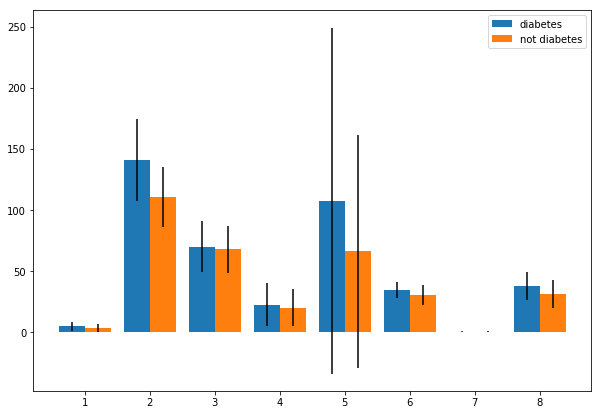

In [86]:
# Visualize
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,9)-0.2,pos_meanstd[0,:],width=0.4,yerr=pos_meanstd[1,:],label='diabetes')
plt.bar(np.arange(1,9)+0.2,neg_meanstd[0,:],width=0.4,yerr=neg_meanstd[1,:],label='not diabetes')
plt.legend()

## 3. Make Predictions

Now that we know the pdf of each feature, we can calculate the probability that a given feature belongs to the positive or negative class.

In [87]:
import math
# This function defines the gaussian pdf and calculates the probability of x belonging to a particular distribution
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

# for example
calculateProbability(x=-3,mean=0,stdev=5)

0.06664492057835994

So we need to calculate the probability that each feature belongs to the positive or negative class.
We can then multiply the probabilities for each feature together because we assume they are independent of one another (not actually the case). 
We will end up with two probabilities, one for each class, and assign the example to the higher probability.

In [124]:
prior = [len(pos_xtrain)/len(X_train), len(neg_xtrain)/len(X_train)] #prior

def getPosteriorprob(X,prior,meanarr1,meanarr2):
    X_lhood = np.zeros((np.size(X,0),2)) #likelihood
    X_evdnce = np.zeros((np.size(X,0),1)) #evidence
    X_post = np.zeros((np.size(X,0),2)) #posterior
    
    for i in np.arange(0,np.size(X,0)): # for all the examples
        predpos = 1
        predneg = 1
    
        for j in np.arange(0,np.size(X,1)): # for all features
            predpos = predpos * calculateProbability(X[i,j],meanarr1[0,j],meanarr1[1,j])
            predneg = predneg * calculateProbability(X[i,j],meanarr2[0,j],meanarr2[1,j])
        
        X_lhood[i,0] = predpos # probability that example is positive
        X_lhood[i,1] = predneg # probability that example is negative
    
        X_evdnce[i,0] = predpos*prior[0] + predneg*prior[1] # evidence
    
        X_post[i,0] = prior[0]*X_lhood[i,0]/X_evdnce[i,0] # posterior for positive
        X_post[i,1] = prior[1]*X_lhood[i,1]/X_evdnce[i,0] # posterior for negative
    return X_post


X_train_post = getPosteriorprob(X_train,prior,pos_meanstd,neg_meanstd)
X_test_post = getPosteriorprob(X_test,prior,pos_meanstd,neg_meanstd)

Now we simply assign a prediction to the higher probability. This is called the Maximum a posteriori (MAP) estimate.

In [140]:
Y_train_pred = np.zeros((np.size(X_train_post,0),))
Y_test_pred = np.zeros((np.size(X_test_post,0),))

def classify(Xmat):
    Y = np.zeros((np.size(Xmat,0),))
    
    for i in np.arange(0,np.size(Xmat,0)):
        if Xmat[i,0] > Xmat[i,1]:
            Y[i] = 1
        else:
            Y[i] = 0
    return Y

Y_train_pred = classify(X_train_post)
Y_test_pred = classify(X_test_post)

In [141]:
print("training accuracy: ",len(np.where(Y_train_pred==Y_train)[0])/len(Y_train))
print("testing accuracy: ",len(np.where(Y_test_pred==Y_test)[0])/len(Y_test))

training accuracy:  0.7431906614785992
testing accuracy:  0.7834645669291339


## 4. Examine data more closely
The classification was better than chance but not great. Let's look at the data to see why this might be. 

#### Assumption 1: Normality. We assumed at the onset that the features were normally distributed. Let's plot histograms to see if this is the case.

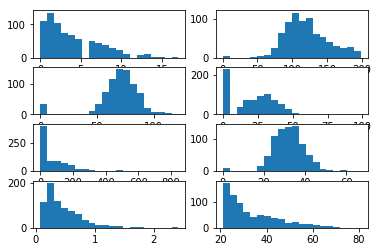

In [144]:
for i in np.arange(0,8):
    plt.subplot(4,2,i+1)
    plt.hist(X[:,i],bins=20)


Clearly most of the features are far from being normally distributed. 

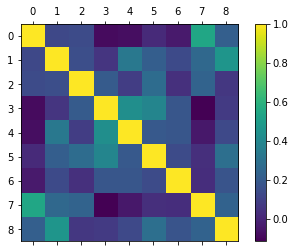

In [148]:
fig = plt.figure()
ax = plt.subplot(111)
cax=ax.matshow(df.corr())
fig.colorbar(cax)

It also looks like the independence assumption is probably wrong too since many of the variables interact with one another. (For example features 0 and 7)